In [1]:
# Import dependencies

#pybaseball is a baseball-specific scraping tool that can pull statistics from several different websites
# Read about it here: https://jamesrledoux.com/projects/open-source/introducing-pybaseball/
import pybaseball
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
from pybaseball import batting_stats

# More basic dependencies
import pandas as pd
import matplotlib.pyplot as plt

# Some extra ones for fun
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as mt

In [39]:
# Added sql part

import sqlite3

In [37]:
# Create a SQL connection to our SQLite database
con = sqlite3.connect("sqlite:///../Resources/baseball.sqlite")

cur = con.cursor()

In [2]:
# Import the data
stat_data2018 = pd.read_csv("resources/sprint_speed_2018.csv")
stat_data2018 = stat_data2018.rename(index=str, columns= {"player_id": "key_mlbam"})

stat_data2019 = pd.read_csv("resources/sprint_speed2019.csv")
stat_data2019 = stat_data2019.rename(index=str, columns= {"player_id": "key_mlbam"})

# NOTE: This was necessary the first time the data was imported.
# An earlier version of this code replaced the original data with the cleaned version and as such, using this over and over would no longer work
# stat_data2018['first_name'] = stat_data2018[' first_name'].str[1:]
# stat_data2018['first_name'] = stat_data2018[' first_name'].str[1:]

In [3]:
# retrieve data on only players who have 50+ plate appearances this year
bat_data2018 = batting_stats(2018, qual=50)
bat_data2019 = batting_stats(2019, qual=50)

In [4]:
fangraphsids_db = pybaseball.playerid_reverse_lookup(stat_data2018.key_mlbam, key_type='mlbam')
fangraphsids_db2 = pybaseball.playerid_reverse_lookup(stat_data2019.key_mlbam, key_type='mlbam')

Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.


In [5]:
labelled18 = stat_data2018.merge(fangraphsids_db, how='left', on='key_mlbam' )
labelled18 = labelled18.drop(columns=['team', 'age'])
labelled19 = stat_data2019.merge(fangraphsids_db2, how='left', on='key_mlbam' )
labelled19 = labelled19.drop(columns=['team', 'age'])

In [6]:
labelled18['Name'] = labelled18['first_name'] + " " + labelled18['last_name']
labelled19['Name'] = labelled19['first_name'] + " " + labelled19['last_name']

In [7]:
total2018 = labelled18.merge(bat_data2018, how='left', on='Name')
total2019 = labelled19.merge(bat_data2019, how='left', on='Name')

In [8]:
CFers = total2018[total2018.position.str.endswith('F')]

In [9]:
total2018.head()

,last_name,first_name,key_mlbam,team_id,position,competitive_runs,hp_to_1b,sprint_speed,name_last,name_first,...,wSL/C (pi),wXX/C (pi),O-Swing% (pi),Z-Swing% (pi),Swing% (pi),O-Contact% (pi),Z-Contact% (pi),Contact% (pi),Zone% (pi),Pace (pi)
0,Buxton,Byron,621439,142,CF,35,3.98,30.5,buxton,byron,...,-1.59,NaN,0.367,0.694,0.532,0.554,0.832,0.737,0.504,22.6
1,Sierra,Magneuris,642423,146,CF,63,3.91,30.2,sierra,magneuris,...,-3.16,NaN,0.411,0.615,0.513,0.595,0.901,0.777,0.496,22.0
2,Quinn,Roman,596451,143,CF,56,3.88,30.2,quinn,roman,...,0.94,NaN,0.235,0.696,0.479,0.452,0.830,0.743,0.529,22.4
3,Engel,Adam,641553,145,CF,181,4.08,30.1,engel,adam,...,-2.48,-2.79,0.394,0.669,0.528,0.513,0.823,0.704,0.486,24.0
4,Hamilton,Billy,571740,113,CF,203,3.94,30.1,hamilton,billy,...,-1.44,-17.84,0.303,0.642,0.476,0.692,0.826,0.784,0.510,21.5


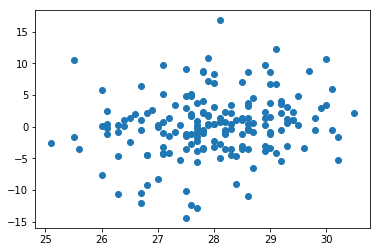

In [10]:
plt.scatter(CFers.sprint_speed, CFers.Fld)

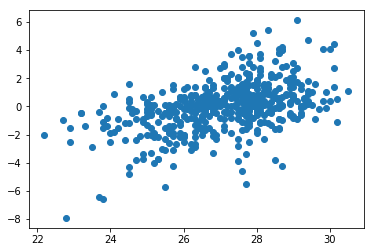

In [11]:
plt.scatter(total2018.sprint_speed, total2018.UBR)


In [12]:
test2018 = CFers[['Name', 'Fld', 'sprint_speed', 'hp_to_1b']]
test2018 = test2018.dropna(subset=['Fld', 'sprint_speed', 'hp_to_1b'])

mdl = RandomForestRegressor()


In [13]:
mdl.fit(test2018[['sprint_speed', 'hp_to_1b']], test2018.Fld)
sco = mdl.score(test2018[['sprint_speed', 'hp_to_1b']], test2018.Fld)
predict = mdl.predict(test2018[['sprint_speed', 'hp_to_1b']])


C:\Users\alana\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


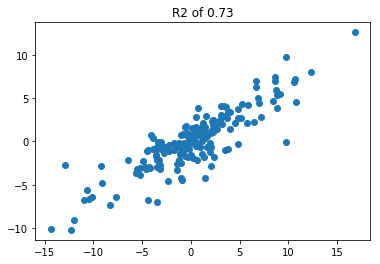

In [14]:
plt.scatter(test2018.Fld, predict)
plt.title(f'R2 of {round(sco,2)}')
plt.show()

In [15]:
test2019 = total2019[total2019.position.str.endswith('F')]
test2019 = test2019[['Name', 'Fld', 'sprint_speed', 'hp_to_1b']]
test2019 = test2019.dropna(subset=['Fld', 'sprint_speed', 'hp_to_1b'])

In [16]:
sco2 = mdl.score(test2019[['sprint_speed', 'hp_to_1b']], test2019.Fld)
predict2 = mdl.predict(test2019[['sprint_speed', 'hp_to_1b']])

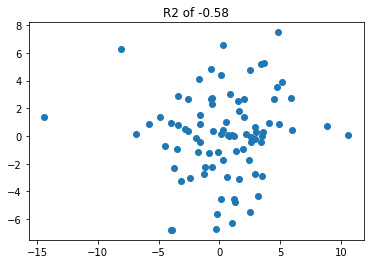

In [17]:
plt.scatter(test2019.Fld, predict2)
plt.title(f'R2 of {round(sco2,2)}')
plt.show()

In [22]:
## WELP. DOESN'T WORK, I GUESS ¯\_(ツ)_/¯.

In [40]:
total2018.to_sql('speed18', con, if_exists='replace', index=False)
total2019.to_sql('speed19', con, if_exists='replace', index=False)

C:\Users\alana\Anaconda3\lib\site-packages\pandas\core\generic.py:2130: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype)


In [58]:
# Example of a sql query which might be performed by an instructor who has poor taste in baseball teams

example = pd.read_sql_query("SELECT * from speed18 WHERE Team='Red Sox'", con)

In [59]:
example

,last_name,first_name,key_mlbam,team_id,position,competitive_runs,hp_to_1b,sprint_speed,name_last,name_first,...,wSL/C (pi),wXX/C (pi),O-Swing% (pi),Z-Swing% (pi),Swing% (pi),O-Contact% (pi),Z-Contact% (pi),Contact% (pi),Zone% (pi),Pace (pi)
0,Betts,Mookie,605141,111,RF,236,4.18,28.1,betts,mookie,...,1.93,NaN,0.185,0.535,0.356,0.658,0.926,0.855,0.490,23.3
1,Bogaerts,Xander,593428,111,SS,270,4.23,27.8,bogaerts,xander,...,2.37,NaN,0.272,0.615,0.432,0.613,0.892,0.798,0.466,26.6
2,Bradley Jr.,Jackie,598265,111,CF,214,4.26,27.8,bradley,jackie,...,-1.38,NaN,0.273,0.678,0.471,0.543,0.789,0.715,0.487,23.6
3,Benintendi,Andrew,643217,111,LF,273,4.23,27.7,benintendi,andrew,...,0.10,NaN,0.270,0.663,0.459,0.756,0.865,0.832,0.481,24.3
4,Lin,Tzu-Wei,624407,111,SS,32,4.22,27.7,lin,tzu-wei,...,-0.94,NaN,0.298,0.586,0.436,0.660,0.788,0.742,0.479,23.1
5,Nunez,Eduardo,456488,111,2B,251,4.25,27.5,nunez,eduardo,...,-1.50,10.47,0.388,0.721,0.536,0.755,0.921,0.854,0.444,25.0
6,Devers,Rafael,646240,111,3B,194,4.30,27.3,devers,rafael,...,0.69,NaN,0.362,0.713,0.519,0.613,0.826,0.744,0.449,23.5
7,Swihart,Blake,596119,111,C,81,4.33,27.1,swihart,blake,...,-3.95,NaN,0.338,0.610,0.472,0.596,0.830,0.745,0.495,23.3
8,Martinez,J.D.,502110,111,DH,260,4.45,26.8,martinez,j. d.,...,0.74,-3.99,0.318,0.736,0.503,0.528,0.849,0.736,0.443,27.5
9,Holt,Brock,571788,111,2B,168,4.39,26.3,holt,brock,...,-1.15,NaN,0.219,0.526,0.375,0.671,0.921,0.849,0.508,24.3


In [60]:
# close it down
con.close()